## GRCh37 New chainSelf and Segdups

This notebook shows the process to generate a new chainSelf file for GRCh37 using `chainSelf.txt.gz` and `chainSelfLink.txt.gz` from the UCSC table browser. This process also uses Aaron Wegners (PacBio) script `hg19.README_annotation.md` (5/22/19)

UCSC files previously downloaded can be obtained using the following commands:

`rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/chainSelf.txt.gz`  
`rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/chainSelfLink.txt.gz`

Note: this process was first run by JM with shell script `Aaron_hg19_step_by_step.sh`. All output files from what was called the "DM" run for datamash, are found in `/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/Files_from_DM_selfchain_prep`

**Working Directory**
`/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains`

#### Summary of Process

**1. Pre-processing**

UCSC chainSelf/Link --> remove trivial (chainSelf only) --> remove alts (chainSelf and Link)

**2. Run Aaron Script to generate selfchain**

**3. Post-Process selfchain**

selfchain --> sort/remove non 1-22,XY --> merge -d100 --> filter merged >10kb --> sum regions

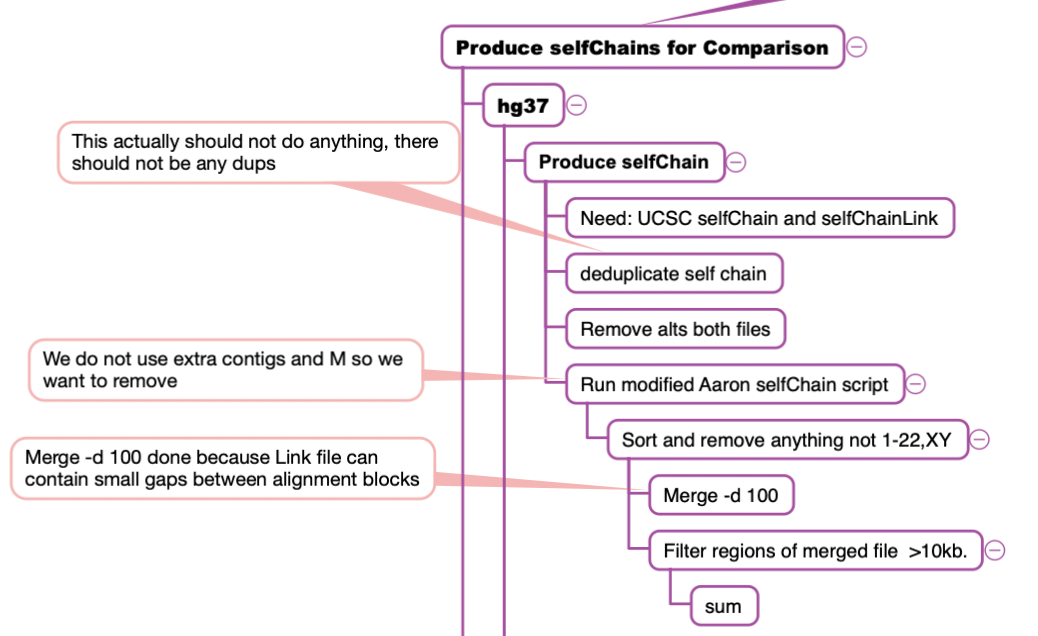

In [2]:
display < /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/img/GRCh37_chainSelf_process.png

### 1) Remove Trivial Regions
This step will remove "trivial" regions, aka regions that map to themselves.

In [1]:
gzcat GRCh37_chainSelf.txt.gz | awk '$3!=$7 || $5!=$10' | bgzip > GRCh37_chainSelf_notrivial.txt.gz

In [3]:
gzcat GRCh37_chainSelf_notrivial.txt.gz | wc -l

 1058543


In [4]:
gzcat GRCh37_chainSelf.txt.gz | wc -l

 1058543


chainSelf did not contain any regions that mapped to itself.

### 2) Remove Alternate Loci
Remove any alternate loci regions. These are regions where "hap" is included in the chromosome name. Alternates will be removed from both the chainSelf and Link files and outputs will be used as input into Aaron script.

**chainSelf**

In [56]:
gzcat GRCh37_chainSelf_notrivial.txt.gz | grep -v hap | bgzip > GRCh37_chainSelf_notrivial_noalts.txt.gz

In [12]:
gzcat GRCh37_chainSelf_notrivial.txt.gz | wc -l

 1058543


In [6]:
gzcat GRCh37_chainSelf_notrivial_noalts.txt.gz | wc -l

  988267


In [13]:
echo $((1058543-988267))

70276


approximately ~70K alternate sites removed from chainSelf.

**chainSelfLink**

In [7]:
gzcat GRCh37_chainSelfLink.txt.gz | grep -v hap | bgzip > GRCh37_chainSelfLink_noalts.txt.gz

In [8]:
gzcat GRCh37_chainSelfLink.txt.gz | wc -l

 6882618


In [10]:
gzcat GRCh37_chainSelfLink.txt.gz | wc -l

 6882618


In [9]:
gzcat GRCh37_chainSelfLink_noalts.txt.gz | wc -l

 6183406


In [11]:
echo $((6882618-6183406))

699212


approximately ~700K alternate sites removed from chainSelfLink.

### 3) Run Aaron Script
code below is modified version of Aaron's selfchain preparation in `hg.19.README_annotation.md`.  His script was broken in to smaller chunks to monitor running and eliminate some issues with running from terminal on the Mac. 

In [16]:
echo "began script at" `date`
gzcat GRCh37_chainSelfLink_noalts.txt.gz \
    | awk '{ print $6 "\t" $3 "\t" $4 "\t" $5 "\t" $5+$4-$3; }' \
    | sort -k1,1 -k2,2g > ./script_intermediates/37_chainSelfLink_intermediate.bed
echo "intermediate finished" `date`

began script at Fri Sep 6 14:06:28 EDT 2019
intermediate finished Fri Sep 6 14:08:17 EDT 2019


In [17]:
echo "began script at" `date`
gzcat GRCh37_chainSelfLink_noalts.txt.gz | awk '{ print $6 "\t" $3 "\t" $4; }' | bedtools merge -d 100 -i - | bedtools intersect -wa -wb -a stdin -b ./script_intermediates/37_chainSelfLink_intermediate.bed | sort -k1,1 -k2,2 -k3,3 | datamash -g1,2,3 min 7 max 8 > ./script_intermediates/37_datamash_intermediate.bed
echo "finished through datamash" `date`

began script at Fri Sep 6 14:08:48 EDT 2019
finished through datamash Fri Sep 6 14:11:01 EDT 2019


In [25]:
echo "began script at" `date`
gzcat GRCh37_chainSelf_notrivial_noalts.txt.gz | awk '{ print $12 "\t" $3 "\t" $7 "\t" $8 "\t" $9 "\t" $13; }' | sort -k1,1 > ./script_intermediates/37_chainSelf_intermediate.bed
echo "finished 37_chainSelf_intermediate.bed" `date`

began script at Fri Sep 6 14:22:08 EDT 2019
finished 37_chainSelf_intermediate.bed Fri Sep 6 14:22:23 EDT 2019


In [26]:
echo "began script at" `date`
join -t $'\t' ./script_intermediates/37_datamash_intermediate.bed ./script_intermediates/37_chainSelf_intermediate.bed > ./script_intermediates/37_joined_intermediate.bed
echo "finished join" `date`

began script at Fri Sep 6 14:22:28 EDT 2019
finished join Fri Sep 6 14:22:34 EDT 2019


In [27]:
echo "began script at" `date`
awk '{ qs=($9=="+")?$4:$8-$5; qe=($9=="+")?$5:$8-$4; printf "%s\t%d\t%d\t%s:%'\''d-%'\''d\t%s\t%d\n", $6, $2, $3, $7, qs+1, qe, $9, int(10*$10); }' ./script_intermediates/37_joined_intermediate.bed| sort -k1,1 -k2,2g | bgzip -c > ./annotation/GRCh37_Aaron_code_chainSelf.bed.gz
tabix -f ./annotation/GRCh37_Aaron_code_chainSelf.bed.gz 
echo "finished selfchain GRCh37_Aaron_code_chainSelf.bed.gz" `date`

began script at Fri Sep 6 14:22:38 EDT 2019
finished selfchain GRCh37_Aaron_code_chainSelf.bed.gz Fri Sep 6 14:23:06 EDT 2019


In [28]:
md5 ./annotation/GRCh37_Aaron_code_chainSelf.bed.gz

MD5 (./annotation/GRCh37_Aaron_code_chainSelf.bed.gz) = 6f68626e109bfb094adc1f3aafede305


### 4) Selfchain post processing
post processing done to remove undesired chromosomes/contigs, merge and filter regions to >10kb

**check to see if sorted and what needs to be removed... "M" and other "un_" extra chroms and needs sorting.**

In [30]:
gzcat ./annotation/GRCh37_Aaron_code_chainSelf.bed.gz | cut -f 1 | uniq

chr1
chr10
chr11
chr11_gl000202_random
chr12
chr13
chr14
chr15
chr16
chr17
chr17_gl000203_random
chr17_gl000204_random
chr17_gl000205_random
chr17_gl000206_random
chr18
chr18_gl000207_random
chr19
chr19_gl000208_random
chr19_gl000209_random
chr1_gl000191_random
chr1_gl000192_random
chr2
chr20
chr21
chr21_gl000210_random
chr22
chr3
chr4
chr4_gl000193_random
chr4_gl000194_random
chr5
chr6
chr7
chr7_gl000195_random
chr8
chr8_gl000196_random
chr8_gl000197_random
chr9
chr9_gl000198_random
chr9_gl000199_random
chr9_gl000200_random
chr9_gl000201_random
chrM
chrUn_gl000211
chrUn_gl000212
chrUn_gl000213
chrUn_gl000214
chrUn_gl000215
chrUn_gl000216
chrUn_gl000217
chrUn_gl000218
chrUn_gl000219
chrUn_gl000220
chrUn_gl000221
chrUn_gl000222
chrUn_gl000223
chrUn_gl000224
chrUn_gl000225
chrUn_gl000227
chrUn_gl000228
chrUn_gl000229
chrUn_gl000230
chrUn_gl000231
chrUn_gl000232
chrUn_gl000233
chrUn_gl000234
chrUn_gl000235
chrUn_gl000236
chrUn_gl000237
chrUn_gl000238
chrUn_gl000239
chrUn_gl000240
chrUn_gl

**Remove non 1-22, XY chromosomes (Remove chrM, chr#_, chr##_ and chrUn) and sort.**

In [44]:
gzcat ./annotation/GRCh37_Aaron_code_chainSelf.bed.gz | sed 's/^chr//' | grep -Ev '^M|^[0-9][0-9]_|[0-9]_|^Un' | sed 's/^X/23/;s/^Y/24/' | sort -k1,1n -k2,2n | sed 's/^23/X/;s/^24/Y/'| bgzip > ./annotation/GRCh37_Aaron_code_chainSelf_sorted.bed.gz 


**Merge Regions**  
This processs will merge regions with maximum distance of 100 bps  
Note: filenames changed as this will be a distributed outputfile, "Aaron_code" removed from filename

In [45]:
gzcat ./annotation/GRCh37_Aaron_code_chainSelf_sorted.bed.gz | bedtools merge -i stdin -d 100 | bgzip > ./annotation/GRCh37_chainSelf_sorted_merged.bed.gz


**merged line count and regions sum for merged output file**

In [46]:
gzcat ./annotation/GRCh37_chainSelf_sorted_merged.bed.gz | wc -l
gzcat ./annotation/GRCh37_chainSelf_sorted_merged.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

   59495
190079658


**Filter to regions >10kb**

In [47]:
gzcat ./annotation/GRCh37_chainSelf_sorted_merged.bed.gz | awk '($3-$2 > 10000)' | bgzip > ./annotation/GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz

**line count and regions sum for filtered output file**

In [48]:
gzcat ./annotation/GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz | wc -l
gzcat ./annotation/GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

    2391
131331831


In [49]:
echo $((190079658-131331831))

58747827


## Segdups
JZ would like to use segmental duplications file in conjunction with self chains.  Like self chain, this file will be merged and filtered to regions >10kb.  The starting file `segdups.bed.gz` was generated by Aaron Wegner (PacBio) using his script `hg19.README_annotation.md`

UCSC Segdups file was downloaded from:
rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/genomicSuperDups.txt.gz

**Summary of Processing**  
segdups.bed.gz -->  sort/remove non 1-22,XY --> merge -d100 --> filter merged >10kb

In [30]:
gzcat hg19.segdups.bed.gz | cut -f 1 | grep -E "_|chr[a-zA-Z]"| uniq

chr11_gl000202_random
chr17_gl000203_random
chr17_gl000204_random
chr17_gl000205_random
chr17_gl000206_random
chr19_gl000209_random
chr1_gl000191_random
chr1_gl000192_random
chr21_gl000210_random
chr4_gl000193_random
chr4_gl000194_random
chr7_gl000195_random
chr8_gl000196_random
chr8_gl000197_random
chr9_gl000198_random
chr9_gl000199_random
chr9_gl000200_random
chr9_gl000201_random
chrUn_gl000211
chrUn_gl000212
chrUn_gl000213
chrUn_gl000214
chrUn_gl000215
chrUn_gl000216
chrUn_gl000217
chrUn_gl000218
chrUn_gl000219
chrUn_gl000220
chrUn_gl000221
chrUn_gl000222
chrUn_gl000223
chrUn_gl000224
chrUn_gl000225
chrUn_gl000227
chrUn_gl000228
chrUn_gl000229
chrUn_gl000230
chrUn_gl000231
chrUn_gl000232
chrUn_gl000233
chrUn_gl000234
chrUn_gl000235
chrUn_gl000236
chrUn_gl000237
chrUn_gl000238
chrUn_gl000239
chrUn_gl000240
chrUn_gl000241
chrUn_gl000242
chrUn_gl000243
chrUn_gl000244
chrUn_gl000245
chrUn_gl000246
chrUn_gl000247
chrUn_gl000248
chrUn_gl000249
chrX
chrY


#### Remove non 1-22, XY chromosomes (Remove chrM, chr#, chr## and chrUn) and sort.

In [52]:
gzcat hg19.segdups.bed.gz | sed 's/^chr//' | grep -Ev '^M|^[0-9][0-9]_|[0-9]_|^Un' | sed 's/^X/23/;s/^Y/24/' | sort -k1,1n -k2,2n | sed 's/^23/X/;s/^24/Y/'| bgzip > ./new_segdups/hg19.segdups_sorted.bed.gz

In [53]:
gzcat hg19.segdups.bed.gz | wc -l

   51599


In [54]:
gzcat ./new_segdups/hg19.segdups_sorted.bed.gz | wc -l

   49948


In [23]:
echo $((51599-49948))

1651


removal of extra chrom/contigs removed 1651 lines (locations)

#### **Merge Regions**  
This processs will merge regions with maximum distance of 100 bps

In [24]:
gzcat ./new_segdups/hg19.segdups_sorted.bed.gz | bedtools merge -i stdin -d 100 | bgzip > ./new_segdups/hg19.segdups_sorted_merged.bed.gz

Stats before merging (line count, regions sum)

In [25]:
gzcat ./new_segdups/hg19.segdups_sorted.bed.gz | wc -l
gzcat ./new_segdups/hg19.segdups_sorted.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

   49948
645134355


Stats after merging (line count, regions sum)

In [26]:
gzcat ./new_segdups/hg19.segdups_sorted_merged.bed.gz | wc -l
gzcat ./new_segdups/hg19.segdups_sorted_merged.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

    7267
160018336


#### Filter to regions >10kb

In [27]:
gzcat ./new_segdups/hg19.segdups_sorted_merged.bed.gz| awk '($3-$2 > 10000)' | bgzip > ./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz

Stats after filtering (line count, regions sum)

In [28]:
gzcat ./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz | wc -l
gzcat ./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

    1795
145351658


## Create "notin" files

In [56]:
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.b37.1_22XY.genome.sorted.bed -b ./annotation/GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz | bgzip > ./annotation/GRCh37_notinchainSelf_sorted_merged_gt10kb.bed.gz
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.b37.1_22XY.genome.sorted.bed -b ./annotation/GRCh37_chainSelf_sorted_merged.bed.gz | bgzip > ./annotation/GRCh37_notinchainSelf_sorted_merged.bed.gz 
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.b37.1_22XY.genome.sorted.bed -b ./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz | bgzip > ./new_segdups/hg19.notinsegdups_sorted_merged_gt10kb.bed.gz
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.b37.1_22XY.genome.sorted.bed -b ./new_segdups/hg19.segdups_sorted_merged.bed.gz | bgzip > ./new_segdups/hg19.notinsegdups_sorted_merged.bed.gz

## md5 checksums

In [58]:
md5 ./new_segdups/hg19.segdups_sorted_merged.bed.gz
md5 ./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz
md5 ./annotation/GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz
md5 ./annotation/GRCh37_chainSelf_sorted_merged.bed.gz
md5 ./new_segdups/hg19.notinsegdups_sorted_merged.bed.gz
md5 ./new_segdups/hg19.notinsegdups_sorted_merged_gt10kb.bed.gz
md5 ./annotation/GRCh37_notinchainSelf_sorted_merged_gt10kb.bed.gz
md5 ./annotation/GRCh37_notinchainSelf_sorted_merged.bed.gz

MD5 (./new_segdups/hg19.segdups_sorted_merged.bed.gz) = 14e02e2092d24886c297d71170bfefb0
MD5 (./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz) = ff88d362fb0ba763b52defdb300a4849
MD5 (./annotation/GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz) = 54026470ca8fc602648356db063e34ba
MD5 (./annotation/GRCh37_chainSelf_sorted_merged.bed.gz) = a997899308d2343150ae7cfc1cf6d4af
MD5 (./new_segdups/hg19.notinsegdups_sorted_merged.bed.gz) = f4c8d96e208ae4056fa4d8bec3768e99
MD5 (./new_segdups/hg19.notinsegdups_sorted_merged_gt10kb.bed.gz) = 2c4a6a79352366716eda70696c09f82a
MD5 (./annotation/GRCh37_notinchainSelf_sorted_merged_gt10kb.bed.gz) = e03447454eaa5b64b225547c7d819662
MD5 (./annotation/GRCh37_notinchainSelf_sorted_merged.bed.gz) = 78724aeeb4977a080695010062d2a29a


## New GRCh37 SelfChain and Segdup Output files
chainself files on JM computer in `/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/annotation`

sedup files on JM computer in `/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/new_segdups`

|File|md5|File Size|Date Generated|
|-|-|-|-|
|GRCh37_chainSelf_sorted_merged_gt10kb.bed.gz|54026470ca8fc602648356db063e34ba|22 KB    |12/11/19|
|GRCh37_chainSelf_sorted_merged.bed.gz       |a997899308d2343150ae7cfc1cf6d4af|470 KB   |12/11/19|
|hg19.segdups_sorted_merged_gt10kb.bed.gz|ff88d362fb0ba763b52defdb300a4849|17 KB| 12/11/19|
|hg19.segdups_sorted_merged.bed.gz|14e02e2092d24886c297d71170bfefb0|65 KB|12/11/19|
|hg19.notinsegdups_sorted_merged.bed.gz|f4c8d96e208ae4056fa4d8bec3768e99|67 KB|12/11/19|
|hg19.notinsegdups_sorted_merged_gt10kb.bed.gz|2c4a6a79352366716eda70696c09f82a|17 KB|12/11/19|
|GRCh37_notinchainSelf_sorted_merged_gt10kb.bed.gz|e03447454eaa5b64b225547c7d819662|22 KB|12/11/19|
|GRCh37_notinchainSelf_sorted_merged.bed.gz|78724aeeb4977a080695010062d2a29a|481 KB|12/11/19|